In [0]:
# reference: https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-8-accuracy/?select=glove.twitter.27B.100d.txt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io



In [33]:
#upload local files - run this code once
# from google.colab import files
# uploaded = files.upload()

Saving glove.twitter.27B.100d.txt to glove.twitter.27B.100d.txt


KeyboardInterrupt: ignored

In [0]:
# read the files
false = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

# data visualization 
# true.head()
# false.head()

In [0]:
true['category'] = 1
false['category'] = 0

In [0]:
#Merging the 2 datasets
df = pd.concat([true,false]) 

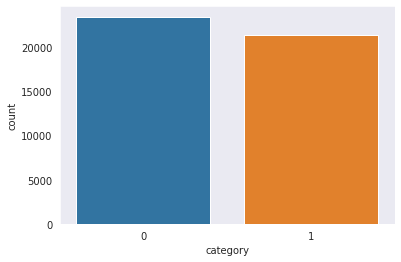

In [38]:
import seaborn as sns
sns.set_style("dark")
sns.countplot(df.category)
#visualization whether the data is balanced between the two classes: fake vs true

In [39]:
# Checking for nan Values
df.isna().sum() 

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [40]:
#total number of titles
df.title.count()

44898

In [41]:
#total number of counts for each type of news
df.subject.value_counts()

# # visualization of the counts 
# import matplotlib.pyplot as plt
# plt.figure(figsize = (10,10))
# sns.set_style("dark")
# chart = sns.countplot(x = "subject", hue = "category" , data = df , palette = 'muted')
# chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [0]:
# SINCE THE TOPICS IN SUBJECT COLUMN ARE DIFFERENT FOR BOTH CATEGORIES, HENCE WE HAVE TO EXCLUDE IT FROM FINAL TEXT COLUMN
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [43]:
# data cleaning = some steps are common but some steps depends on the data

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re,string,unicodedata
from string import punctuation
from bs4 import BeautifulSoup


stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df['text']=df['text'].apply(denoise_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# # #wordcloud generation
# from wordcloud import WordCloud,STOPWORDS

# # Text that is not Fake
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 1].text))
# plt.imshow(wc , interpolation = 'bilinear')

# # Text that is Fake
# plt.figure(figsize = (20,20)) 
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.category == 0].text))
# plt.imshow(wc , interpolation = 'bilinear')

In [0]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import text, sequence

# Splitting the data into 2 parts - training and testing data
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer
# Tokenized applies basic processing like changing it to lower case, explicitely setting that as False
# Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

max_features = 10000
maxlen = 300

# this explains fit_on_texts vs texts_to_sequences: https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [0]:
# glove embedding
EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
    
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [54]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [0]:
from keras.callbacks import ReduceLROnPlateau

# some model parameters
batch_size = 256
epochs = 10
embed_size = 100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

Here we are using the sequential way to build the deep learning networks. 
It allows us to stack layers into the network

The first layer is a word embedding layer -- convert our words (referenced by integers in the data) into meaningful embedding vectors. This Embedding() layer takes the size of the vocabulary as its first argument, then the size of the resultant embedding vector that you want as the next argument. Finally, because this layer is the first layer in the network, we must specify the “length” of the input i.e. the number of steps/words in each sample.

https://adventuresinmachinelearning.com/keras-lstm-tutorial/ -- this links describes the different parameters for LSTM

In [0]:
# training the model
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy']) #if there is more than two class use 'categorical_crossentropy' instead


In [59]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [60]:
# train the model 
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

Train on 33673 samples, validate on 11225 samples
Epoch 1/10
33673/33673 [==============================] - 438s 13ms/step - loss: 0.1653 - accuracy: 0.9337 - val_loss: 0.0460 - val_accuracy: 0.9837
Epoch 2/10
33673/33673 [==============================] - 442s 13ms/step - loss: 0.0467 - accuracy: 0.9843 - val_loss: 0.0208 - val_accuracy: 0.9936
Epoch 3/10
33673/33673 [==============================] - 447s 13ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.0066 - val_accuracy: 0.9980
Epoch 4/10
33673/33673 [==============================] - 443s 13ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0083 - val_accuracy: 0.9971
Epoch 5/10
33673/33673 [==============================] - 447s 13ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.0108 - val_accuracy: 0.9971

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 6/10
33673/33673 [==============================] - 448s 13ms/step - loss: 0.0066 - accuracy: 0.9977 - val_loss: 0.0051

In [61]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

33673/33673 [==============================] - 130s 4ms/step
Accuracy of the model on Training Data is -  99.99108910560608
11225/11225 [==============================] - 46s 4ms/step
Accuracy of the model on Testing Data is -  99.89309310913086
